In [15]:
import cv2
import numpy as np
import random

In [3]:
import pickle
from reusable import load

data = load.load_data()

print("Done!")

X_train, y_train = (data.train.features, data.train.labels)

Loading project data.
Data already unzipped.
Returning ProjectData(train, test).
Done!


In [84]:
## Based on this paper, http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf
## Samples are randomly perturbed 
##  in position ([-2,2] pixels), 
##  in rotation ([-15,+15] degrees)
##  in brightness ([0.7, 2.0] gamma)
def transform_image(img, min_gamma=0.7, max_gamma=2.0, shift=2, angle=15.0):
  img = change_image_gamma(img, min_gamma=min_gamma, max_gamma=max_gamma)
  img = shift_image(img, shift=shift)
  return rotate_image(img, angle=angle)
  
def shift_image(img, shift=4):
  rows,cols,channels = img.shape
  x_shift = random.randint(-shift, shift)
  y_shift = random.randint(-shift, shift)
  M = np.float32([[1,0,x_shift],[0,1,y_shift]])
  return cv2.warpAffine(img,M,(cols,rows))

def rotate_image(img, angle=20.0):
  rows,cols,channels = img.shape
  rotation_angle = random.uniform(-angle, angle)
  M = cv2.getRotationMatrix2D((cols/2,rows/2),rotation_angle,1)
  return cv2.warpAffine(img,M,(cols,rows))

def darken_image(img, gamma_delta=0.5):
  gamma = 1 - random.uniform(0.0, gamma_delta)
  return _change_image_gamma(img, gamma)

def change_image_gamma(img, min_gamma=0.7, max_gamma=2.0):
  # build a lookup table mapping the pixel values [0, 255] to
  # their adjusted gamma values
  gamma = random.uniform(min_gamma, max_gamma)
  invGamma = 1.0 / gamma
  table = np.array([((i / 255.0) ** invGamma) * 255
  for i in np.arange(0, 256)]).astype("uint8")
 
  # apply gamma correction using the lookup table
  return cv2.LUT(img, table)

(32, 32, 3)


(<matplotlib.axes._subplots.AxesSubplot at 0x12a0f0c50>,
 <matplotlib.text.Text at 0x12a22d668>)

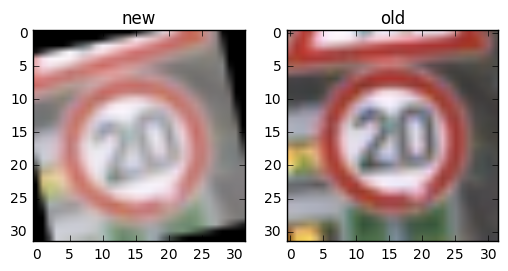

In [86]:
import matplotlib.pyplot as plt
%matplotlib inline
old = X_train[10]
new = transform_image(old)
old.squeeze()
new.squeeze()

print(new.shape)

plt.subplot(121),plt.imshow(new),plt.title('new')
plt.subplot(122),plt.imshow(old),plt.title('old')

In [87]:
from sklearn.utils import shuffle

### Normalize data
def scale(X_data):
  return np.divide(np.subtract(np.array(X_data, dtype='float32'), 128), 128)

def to_greyscale(X_data):
  return [rgb2gray(image) for image in X_data]

def rgb2gray(rgb):
    gray = np.dot(rgb[...,:3], [0.299, 0.587, 0.114])
    return [[[val] for val in row] for row in gray]

In [115]:
## Add jiggered data

unique, counts = np.unique(y_train, return_counts=True)
# dict of original images
train_dict = {u: [] for u in unique}
# dict where we where add jiggered data
jiggered_dict = {u: [] for u in unique}

for i in range(len(X_train)):
  train_dict[y_train[i]].append(X_train[i])
  jiggered_dict[y_train[i]].append(X_train[i])

max_img_count = max(counts)
for k in train_dict.keys():
  # add (max_image_count - kth_image_count) jiggered images
  for i in range(counts[k], max_img_count):
    old_i = random.randint(0, len(train_dict[k]) - 1)
    jiggered_dict[k].append(transform_image(train_dict[k][old_i]))
    
print([(i, len(jiggered_dict[i])) for i in jiggered_dict.keys()])
  


[(0, 2250), (1, 2250), (2, 2250), (3, 2250), (4, 2250), (5, 2250), (6, 2250), (7, 2250), (8, 2250), (9, 2250), (10, 2250), (11, 2250), (12, 2250), (13, 2250), (14, 2250), (15, 2250), (16, 2250), (17, 2250), (18, 2250), (19, 2250), (20, 2250), (21, 2250), (22, 2250), (23, 2250), (24, 2250), (25, 2250), (26, 2250), (27, 2250), (28, 2250), (29, 2250), (30, 2250), (31, 2250), (32, 2250), (33, 2250), (34, 2250), (35, 2250), (36, 2250), (37, 2250), (38, 2250), (39, 2250), (40, 2250), (41, 2250), (42, 2250)]


In [131]:
X_train_jiggered = np.concatenate([v for v in jiggered_dict.values()])
y_train_jiggered = np.concatenate([[i for j in range(max_img_count)] for i in jiggered_dict.keys()])
X_train_jiggered, y_train_jiggered = shuffle(X_train_jiggered, y_train_jiggered)

In [134]:
import pickle

pickle.dump( (X_train_jiggered, y_train_jiggered), open( "train_jiggered.p", "wb" ) )


In [135]:
X_train_jiggered, y_train_jiggered = (None, None)

In [136]:
X_train_jiggered, y_train_jiggered = pickle.load( open( "train_jiggered.p", "rb" ) )

In [139]:
print(len(y_train))

39209
